# ARCH models

**Ссылки**:

[ARCH Univariate Volatility Models](https://bashtage.github.io/arch/univariate/univariate.html)

[ARCH, GARCH, EGARCH](https://medium.com/@NNGCap/arch-garch-egarch-92dd7277a966)

[How to Model Volatility with ARCH and GARCH for Time Series Forecasting in Python](https://machinelearningmastery.com/develop-arch-and-garch-models-for-time-series-forecasting-in-python/)

In [19]:
import pandas as pd
import numpy as np
import tqdm

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline

from arch import arch_model

In [20]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [21]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

## ARCH

AutoRegressive Conditional Heteroscedasticit - пытаемся объяснить дисперсию в ряде через предыдущие значения (применяя к ним AR)

Пусть временной ряд представляется в таком виде:

$u_t = \epsilon_t * \sqrt{\alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2}$

Тогда условная дисперсия ряда будет равна

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2$

Получили модель ARCH(q) условной дисперсии. Требуем, чтобы все коэффициенты были больше 0 (иначе может получится отрицательная дисперсия)

### Simulate ARCH(1) series

Results of Dickey-Fuller Test:
Test Statistic                 -31.510128
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


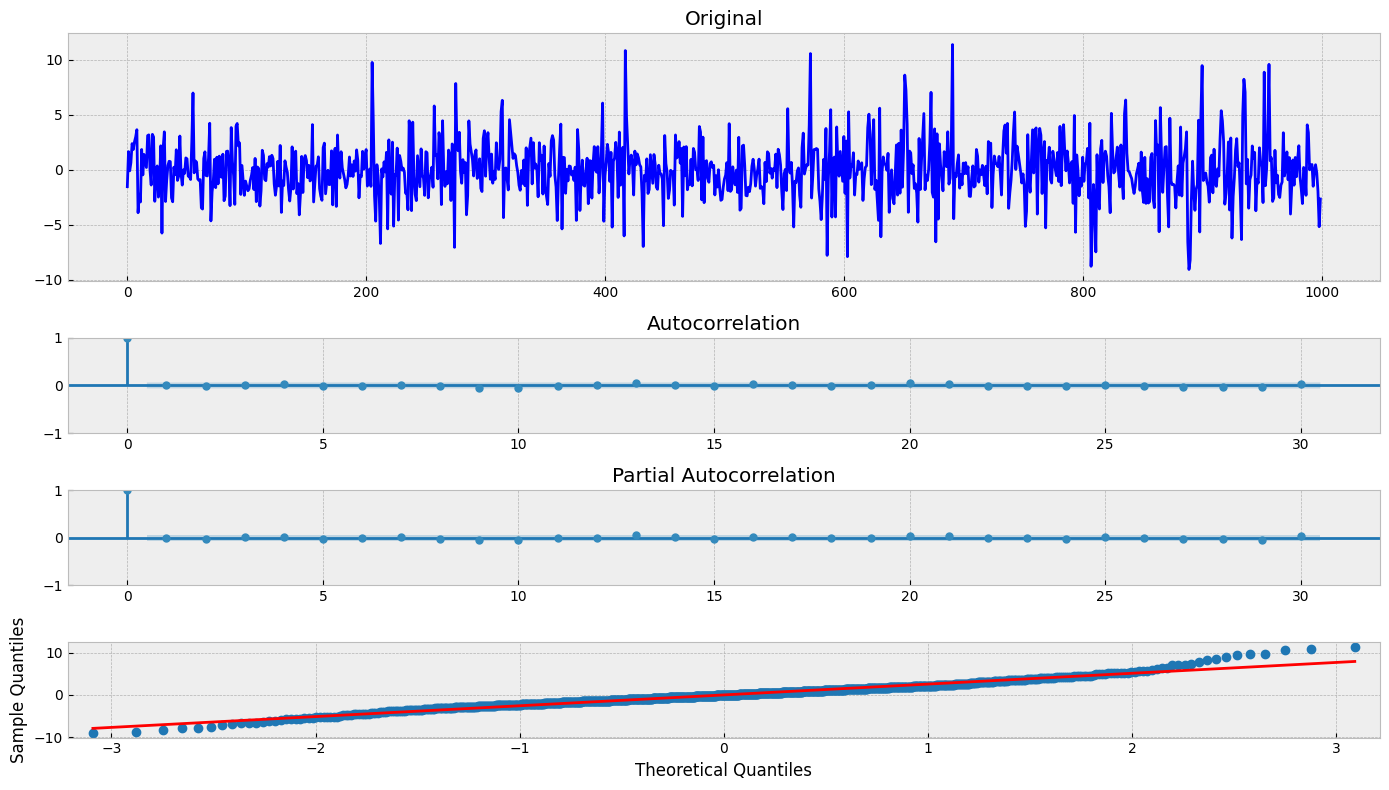

In [22]:
np.random.seed(13)

a0 = 2
a1 = 5.5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=30)

### Строим ARCH модель

Самый простой способ построить эту модель - использовать функцию-конструктор **arch_model()**

In [26]:
am = arch_model(Y)

In [27]:
res = am.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4186.939087750192
Iteration:      2,   Func. Count:     13,   Neg. LLF: 41316.30666002385
Iteration:      3,   Func. Count:     19,   Neg. LLF: 2340.419528124783
Iteration:      4,   Func. Count:     26,   Neg. LLF: 2483.04297511564
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2269.794316518769
Iteration:      6,   Func. Count:     37,   Neg. LLF: 2269.3866747944894
Iteration:      7,   Func. Count:     42,   Neg. LLF: 2268.855139031047
Iteration:      8,   Func. Count:     47,   Neg. LLF: 2268.8186588361236
Iteration:      9,   Func. Count:     52,   Neg. LLF: 2268.8103690841303
Iteration:     10,   Func. Count:     57,   Neg. LLF: 2268.8078012785654
Iteration:     11,   Func. Count:     62,   Neg. LLF: 2280.3798790782794
Iteration:     12,   Func. Count:     70,   Neg. LLF: 2269.0101111240283
Iteration:     13,   Func. Count:     77,   Neg. LLF: 2268.9619764701392
Iteration:     14,   Func. Count:     83,   Neg. LLF: 2268

In [28]:
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2268.81
Distribution:                  Normal   AIC:                           4545.62
Method:            Maximum Likelihood   BIC:                           4565.25
                                        No. Observations:                 1000
Date:                Wed, May 29 2024   Df Residuals:                      999
Time:                        22:22:23   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.1028  5.842e-02     -1.760  7.837e-02 [ -0.217,